In [1]:
!git clone https://github.com/MarceloGennari/diffusion_mnist.git
%cd diffusion_mnist

Cloning into 'diffusion_mnist'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 90 (delta 48), reused 63 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 20.72 KiB | 3.45 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/diffusion_mnist


In [2]:
!ls

diffusion_model.py	inference_unet.py  main.py	     models
inference_unet_DDIM.py	LICENSE		   mnist_dataset.py  README.md


In [3]:
with open("mnist_dataset.py", "r") as f:
    print(f.read())

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script has been adapted from https://nextjournal.com/gkoehler/pytorch-mnist
"""

from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from typing import Tuple


def get_mnist_dataloader(batch_size: int = 256) -> Tuple[DataLoader, DataLoader]:
    """
    Convenient helper function to get the loaders for the mnist dataset
    Args:
        batch_size (int): the size of batches

    Returns:
        Tuple[DataLoader, DataLoader]: train loader and test loader respectively
    """
    to_tensor = torchvision.transforms.ToTensor()
    normalize = torchvision.transforms.Normalize((0.1307,), (0.3081,))
    transform = torchvision.transforms.Compose([to_tensor, normalize])

    trainset = MNIST("./data/", train=True, download=True, transform=transform)
    testset = MNIST("./data/", train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_s

In [4]:
with open("main.py", "r") as f:
    print(f.read())

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script is used to train the UNet to predict the noise at different
timestamps of the diffusion process. The loss function is a simple mean
squared error between the actual noise and the predicted noise based on
the diffused image, according to the original paper: 
https://arxiv.org/pdf/2006.11239.pdf
"""

from tqdm import tqdm, trange

import torch
from torch import optim
from mnist_dataset import get_mnist_dataloader
from diffusion_model import DiffusionProcess

from models import ConditionalUNet

if __name__ == "__main__":
    # Prepare images
    trainloader, testloader = get_mnist_dataloader()
    idx, (images, labels) = next(enumerate(testloader))

    # Prepare model and training
    device = "cpu"
    model = ConditionalUNet().to(device)
    process = DiffusionProcess()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 80)
    criterion = torch.nn.M

In [5]:
with open("diffusion_model.py", "r") as f:
    print(f.read())

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com
"""
import torch
from torch import Tensor
from typing import List


class DiffusionProcess:
    """
    Class that implements the forward and inverse diffusion process according to
    the DDPM paper: https://arxiv.org/pdf/2006.11239.pdf

    Attributes:
        variance_schedule (torch.Tensor): list with the variance value at each
            timestep according to DDPM paper
        alpha (torch.Tensor): list of "complement" values for variance defined
            in the DDPM paper. It is the same as 1-variance_schedule
        alpha_bar (torch.Tensor): cummulative product defined int he DDPM
            paper above. It is derived directly from the variance schedule
    """

    def __init__(self, variance_schedule: List[float] = None) -> None:
        """
        Args:
            variance_schedule (list): list with the variance value at each
                timestep according to DDPM paper. If left None, it will defa

In [6]:
with open("inference_unet.py", "r") as f:
    print(f.read())

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script performs the sampling given the trained UNet model
"""
from tqdm import trange

import torch
from models import ConditionalUNet
from diffusion_model import DiffusionProcess

import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Prepare model
    device = "cpu"
    batch_size = 100
    model = ConditionalUNet().to(device)
    model.load_state_dict(torch.load("unet_mnist.pth"))
    process = DiffusionProcess()

    # Sampling
    xt = torch.randn(batch_size, 1, 28, 28)
    digit_to_sample = torch.Tensor([9]).to(dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        for t in trange(999, -1, -1):
            time = torch.ones(batch_size) * t
            et = model(xt.to(device), time.to(device), digit_to_sample)  # predict noise
            xt = process.inverse(xt, et.cpu(), t)

    labels = ["Generated Images"] * 9

    for i in range(9):
        plt.subplot(3, 3, i + 1)
 

In [7]:
with open("inference_unet_DDIM.py", "r") as f:
    print(f.read())

"""
Marcelo Gennari do Nascimento, 2022
marcelogennari@outlook.com

This script performs sampling by using the DDIM algorithm, which is a
deterministic solution to the generation of images:
https://arxiv.org/abs/2010.02502

It is supposed to be 10x to 100x quicker, and it uses the same training 
procedure as DDPM, so the trained model can be reused here
"""

from tqdm import trange

import torch
from models import UNet
from diffusion_model import DiffusionProcess

import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Prepare model
    device = "cpu"
    batch_size = 100
    model = UNet().to(device)
    model.load_state_dict(torch.load("unet_mnist.pth"))
    process = DiffusionProcess()

    # Sampling
    xt = torch.randn(batch_size, 1, 28, 28)
    digit_to_sample = torch.Tensor([9]).to(dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        for t in trange(999, -1, -1):
            time = torch.ones(batch_size) * t
            et = model(xt.to(dev

In [8]:
# mnist_dataset.py 코드 분석 부분(MNIST 손글씨 숫자 데이터셋 불러옴)

from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from typing import Tuple


def get_mnist_dataloader(batch_size: int = 256) -> Tuple[DataLoader, DataLoader]: # 입력인자 : batch_size / 출력인자 : DataLoader 2개
    # transform : 데이터 전처리 과정
    to_tensor = torchvision.transforms.ToTensor() # 전처리 과정1
    normalize = torchvision.transforms.Normalize((0.1307,), (0.3081,)) # 전처리 과정2 : 정규화
    transform = torchvision.transforms.Compose([to_tensor, normalize]) # 순차적으로 전처리 과정 적용

    trainset = MNIST("./data/", train=True, download=True, transform=transform)
    testset = MNIST("./data/", train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 데이터를 배치 단위로 자동으로 나누어 로딩함
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # test 데이터는 shuffle X

    return trainloader, testloader

In [9]:
# diffusion_model.py 코드 분석 부분

import torch
from torch import Tensor
from typing import List


class DiffusionProcess:
    # 초기화 과정
    def __init__(self, variance_schedule: List[float] = None) -> None:
        if variance_schedule is None:
            variance_schedule = torch.linspace(1e-4, 0.01, steps=1000) # linspace : 선형적으로 생성
        self.variance_schedule = Tensor(variance_schedule)
        self.alpha = 1 - self.variance_schedule
        self.alpha_bar = torch.cumprod(self.alpha, dim=0) # 누적된 정보량

    # Forward process(노이즈 추가함)
    def forward(self, x_0: Tensor, time_step: Tensor, noise: Tensor) -> Tensor:
        # Checking for validity of input
        assert torch.all(time_step >= 0).item()
        assert torch.all(time_step < len(self.alpha_bar)).item()
        assert time_step.shape[0] == x_0.shape[0]
        std_dev = torch.sqrt(1 - self.alpha_bar[time_step])
        mean_multiplier = torch.sqrt(self.alpha_bar[time_step])

        # This makes sure that variance and mean multiplier are both broadcastable
        std_dev = std_dev[:, None, None, None].to(x_0.device)
        mean_multiplier = mean_multiplier[:, None, None, None].to(x_0.device)

        diffused_images = mean_multiplier * x_0 + std_dev * noise
        return diffused_images # 원래 이미지에 노이즈가 추가된 이미지들

    # Reverse diffusion process(노이즈 있는 이미지에서 다시 되돌림) / DDPM에서 사용되는 부분(랜덤성이 키포인)
    def inverse(self, xt: Tensor, et: Tensor, t: int) -> Tensor:
        scale = 1 / torch.sqrt(self.alpha[t])
        noise_scale = (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_bar[t])
        std_dev = torch.sqrt(self.variance_schedule[t])
        mu_t = scale * (xt - noise_scale * et)

        z = torch.randn(xt.shape) if t > 1 else torch.Tensor([0]) # randn : 랜덤성 추가
        xt = mu_t + std_dev * z  # remove noise from image
        return xt

    # Deterministic reverse : DDPM의 변형 과정으로 이미지 복원 시 랜덤성 없음
    def inverse_DDIM(self, xt: Tensor, et: Tensor, t: int) -> Tensor:
        den = 1 / torch.sqrt(self.alpha_bar[t])
        f_theta = (xt - torch.sqrt(1 - self.alpha_bar[t]) * et) * den # 추정된 noise-free값
        if t > 0:
            part1 = torch.sqrt(self.alpha_bar[t - 1]) * f_theta
            part2 = torch.sqrt(1 - self.alpha_bar[t - 1])
            den = 1 / torch.sqrt(1 - self.alpha_bar[t])
            scale = (xt - torch.sqrt(self.alpha_bar[t]) * f_theta) * den
            xt = part1 + part2 * scale
        else:
            xt = f_theta

        return xt

In [10]:
# train_unet.py 코드 분석 부분(실제로 UNet을 학습시키는 목적)
# MNIST 이미지 → 노이즈 추가 → 모델이 노이즈 예측 → 예측된 노이즈와 실제 노이즈 비교 → MSE 손실로 학습
from tqdm import tqdm, trange

import torch
from torch import optim
from mnist_dataset import get_mnist_dataloader
from diffusion_model import DiffusionProcess

from models import ConditionalUNet

if __name__ == "__main__":
    # Prepare images
    trainloader, testloader = get_mnist_dataloader()
    idx, (images, labels) = next(enumerate(testloader))

    # Prepare model and training
    device = "cpu"
    model = ConditionalUNet().to(device)
    process = DiffusionProcess()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 80) #80epoch마다 학습률 감소함
    criterion = torch.nn.MSELoss()

    # 학습 루프
    epochs = 3
    for e in trange(epochs):
        running_loss = 0
        progress_bar = tqdm(trainloader, leave=False)
        for image, label in progress_bar:
            # Forward 과정: 노이즈 추가
            t = torch.randint(0, 1000, (image.shape[0],)) # 랜덤 시간 간격
            epsilon = torch.randn(image.shape) # 랜덤 노이즈 추가
            diffused_image = process.forward(image, t, epsilon)

            # Backprop
            optimizer.zero_grad()
            output = model(diffused_image.to(device), t.to(device), label.to(device)) # 노이즈값 예측
            # 손실 계산, 역전파
            loss = criterion(epsilon.to(device), output)
            loss.backward()
            optimizer.step()
            loss_value = loss.cpu().item()
            running_loss += loss_value
            progress_bar.set_description(f"Loss: {loss_value:.4f}")

        scheduler.step()

        # 모델 저장, 로그 출력
        torch.save(model.state_dict(), "unet_mnist.pth")

        # Logging results
        running_loss /= len(trainloader)
        tqdm.write(f"Mean loss for Epoch {e + 1}: {running_loss:.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.19MB/s]
 33%|███▎      | 1/3 [35:31<1:11:03, 2131.88s/it]

Mean loss for Epoch 1: 0.3941



 67%|██████▋   | 2/3 [1:14:20<37:27, 2247.37s/it]  

Mean loss for Epoch 2: 0.1036



100%|██████████| 3/3 [1:50:37<00:00, 2212.66s/it]

Mean loss for Epoch 3: 0.0866


### - 훈련 단계에서는 DDPM을 사용하여 고품질의 이미지를 생성할 수 있도록 훈련시킴.

### - 생성(inference) 단계에서는 DDIM을 사용하여 빠르고 일관된 결과를 얻을 수 있게 함.

# <훈련과 생성에서의 역할 차이>
### - 훈련(Training): DDPM 방식으로 노이즈 제거를 학습하고, 모델은 노이즈를 예측하는 능력을 점진적으로 키워가며 이미지 품질을 높임.

### - 생성(Inference): DDIM 방식으로 빠르고 일관된 이미지 생성을 할 수 있음. 훈련된 모델을 사용하여, 더 빠르게 이미지를 생성할 수 있도록 하고, 빠른 샘플링이 가능하도록 한다.

100%|██████████| 1000/1000 [16:40<00:00,  1.00s/it]


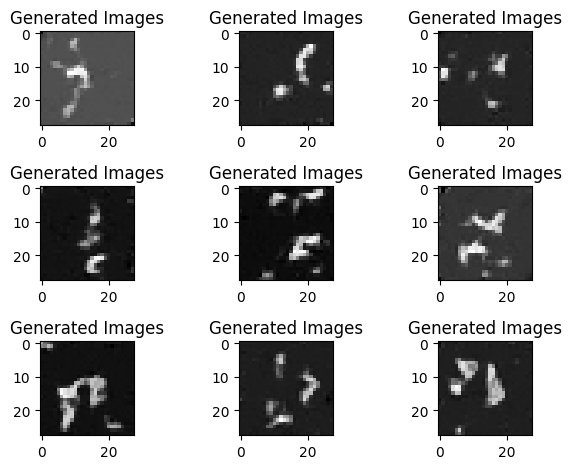

In [13]:
# inference_unet_DDIM.py 코드 분석 부분 -> DDIM 사용 => 빠른 생성 속도, 일관성
# 훈련된 UNet 모델로 실제로 이미지 생성함
from tqdm import trange

import torch
from models import ConditionalUNet # Changed UNet to ConditionalUNet
from diffusion_model import DiffusionProcess

import matplotlib.pyplot as plt

if __name__ == "__main__":
    # 환경 및 모델 준비
    device = "cpu"
    batch_size = 100
    model = ConditionalUNet().to(device) # Changed UNet to ConditionalUNet
    model.load_state_dict(torch.load("unet_mnist.pth"))
    process = DiffusionProcess()

    # 초기 노이즈 샘플링
    xt = torch.randn(batch_size, 1, 28, 28)
    digit_to_sample = torch.Tensor([9]).to(dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        for t in trange(999, -1, -1):
            time = torch.ones(batch_size) * t
            et = model(xt.to(device), time.to(device), digit_to_sample)  # 모델이 예측한 노이즈값
            xt = process.inverse_DDIM(xt, et.cpu(), t) # 현재의 이미지

    labels = ["Generated Images"] * 9

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.tight_layout()
        plt.imshow(xt[i][0], cmap="gray", interpolation="none")
        plt.title(labels[i])
    plt.show()

100%|██████████| 1000/1000 [16:40<00:00,  1.00s/it]


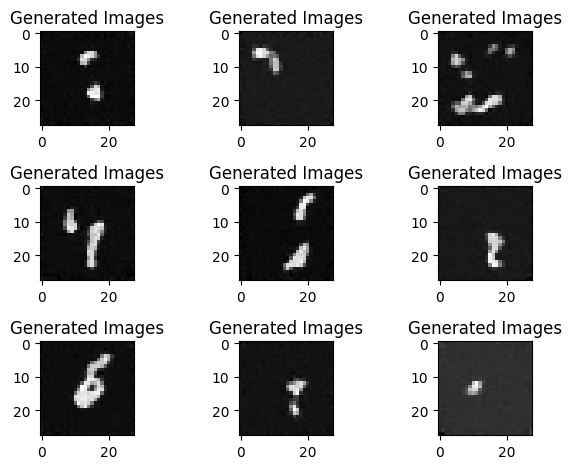

In [14]:
# inference_unet.py 코드 분석 부분 -> Inverse 사용(DDPM)
from tqdm import trange

import torch
from models import ConditionalUNet
from diffusion_model import DiffusionProcess

import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Prepare model
    device = "cpu"
    batch_size = 100
    model = ConditionalUNet().to(device)
    model.load_state_dict(torch.load("unet_mnist.pth"))
    process = DiffusionProcess()

    # Sampling
    xt = torch.randn(batch_size, 1, 28, 28)
    digit_to_sample = torch.Tensor([9]).to(dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        for t in trange(999, -1, -1):
            time = torch.ones(batch_size) * t
            et = model(xt.to(device), time.to(device), digit_to_sample)  # predict noise
            xt = process.inverse(xt, et.cpu(), t) # DDIM과 다른 점

    labels = ["Generated Images"] * 9

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.tight_layout()
        plt.imshow(xt[i][0], cmap="gray", interpolation="none")
        plt.title(labels[i])
    plt.show()